Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Read Data from CSV

In [ ]:
import os
import cv2
import torch
import pickle
import albumentations
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# finalDataPath = "img_data.csv"
finalDataPath = "gdrive/My Drive/model/img_data.csv"

data = pd.read_csv(finalDataPath)

In [ ]:
data.head()

,image,text
0,TRSynth100K/images/00000000.jpg,life
1,TRSynth100K/images/00000001.jpg,not
2,TRSynth100K/images/00000002.jpg,while
3,TRSynth100K/images/00000003.jpg,know
4,TRSynth100K/images/00000004.jpg,clearly


Modify Pathnames for Use on Google Drive

In [ ]:
for i in range(len(data["image"])):
    data["image"][i] = "gdrive/My Drive/model/" + data["image"][i]

Create Text Mapping Alphabet

In [ ]:
alphabet = list({c for word in data['text'] for c in str(word)})
alphabet.sort()

In [ ]:
alphabet

['#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [ ]:
charToInt = {a: i + 1 for i, a in enumerate(alphabet)}
intToChar = {i + 1: a for i, a in enumerate(alphabet)}

In [ ]:
def save_obj(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

save_obj(charToInt, "charToInt.pkl")
save_obj(intToChar, "intToChar.pkl")

Split Data Into Train and Validation Data

In [ ]:
train, valid = train_test_split(data, test_size=0.2)

Load and Normalize Image Data

In [ ]:
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

trainImg = []
trainImgLen = []
trainText = []
trainTextLen = []
validImg = []
validImgLen = []
validText = []
validTextLen = []

maxLen = data["text"].apply(lambda x: len(str(x))).max()
aug = albumentations.Compose([albumentations.Normalize(max_pixel_value = 255, always_apply = True)])

for i in range(int(len(train) * 0.3)):
    img = cv2.imread(train["image"][i])
    if type(img) == type(None):
        continue
    img = aug(image = img)["image"]
    trainImg.append(img)
    trainText.append([charToInt[j] for j in str(train['text'][i])])
    trainText[i] = [0] * (maxLen - len(trainText[i])) + trainText[i]
    trainImgLen.append(39)
    trainTextLen.append(maxLen)

for i in range(int(len(valid) * 0.3)):
    img = cv2.imread(valid["image"][i])
    if type(img) == type(None):
        continue
    img = aug(image = img)["image"]
    validImg.append(img)
    validText.append([charToInt[j] for j in str(valid['text'][i])])
    validText[i] = [0] * (maxLen - len(validText[i])) + validText[i]
    validImgLen.append(39)
    validTextLen.append(maxLen)

trainImg = np.array(trainImg)
trainText = np.array(trainText)
trainImgLen = np.array(trainImgLen)
trainTextLen = np.array(trainTextLen)
validImg = np.array(validImg)
validText = np.array(validText)
validImgLen = np.array(validImgLen)
validTextLen = np.array(validTextLen)


[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 56 58 75 64 70 69]
24000
6000


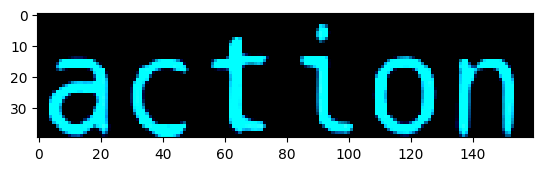

In [ ]:
plt.imshow(trainImg[0])
print(trainText[0])
print(len(trainImg))
print(len(validText))

Build Model

In [ ]:
rcnn = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (40, 160, 3)),

    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = 2),

    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = "relu", padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = 2),

    tf.keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), activation = "relu", padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.MaxPool2D(pool_size = (2, 1)),

    tf.keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), activation = "relu", padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(0.2),

    tf.keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), activation = "relu", padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.MaxPool2D(pool_size = (2, 1)),

    tf.keras.layers.Conv2D(filters = 512, kernel_size = (2, 2), activation = "relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(0.2),

    tf.keras.layers.Reshape((-1, 512)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True, dropout = 0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True, dropout = 0.2))
])
output = tf.keras.layers.Dense(len(alphabet) + 1, activation = "softmax")
rcnn.build()

In [ ]:
rcnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 40, 160, 64)         │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 40, 160, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 40, 160, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 20, 80, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 20, 80, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 20, 80, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 20, 80, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 40, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 40, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 10, 40, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 10, 40, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 40, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 5, 40, 256)          │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 5, 40, 256)          │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 5, 40, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 40, 512)          │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 5, 40, 512)          │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 5, 40, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 40, 512)          │              

 Total params: 4,247,680 (16.20 MB)

 Trainable params: 4,244,224 (16.19 MB)

 Non-trainable params: 3,456 (13.50 KB)

Define CTC Loss Function

In [ ]:
def ctc_loss(yTrue, yPred):
    trainImgLenTemp = tf.cast(trainImgLen, tf.int64)
    trainTextLenTemp = tf.cast(trainTextLen, tf.int64)
    return tf.keras.backend.ctc_batch_cost(yTrue, yPred, trainImgLenTemp, trainTextLenTemp)


Train the Model

In [ ]:
rcnn.compile(loss = tf.keras.losses.CTC(), optimizer = 'adam')
ecks = [trainImg, trainText, trainImgLen, trainTextLen]
vee = [validImg, validText, validImgLen, validTextLen]
rcnn.fit(x = trainImg, y = trainText, validation_data = (validImg, validText), batch_size = 256, epochs = 5)

Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 3365s 36s/step - loss: 139.5270 - val_loss: 121.0055
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 3441s 36s/step - loss: 120.8385 - val_loss: 120.9016
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 3463s 36s/step - loss: 120.8395 - val_loss: 120.3605
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 3477s 37s/step - loss: 120.3681 - val_loss: 120.3471
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 3444s 36s/step - loss: 120.3604 - val_loss: 120.3426


In [ ]:
rcnn.save("gdrive/My Drive/model/rcnn.keras")